### Titulo

#### explicacion despues de aplicar los primeros dos pasos del metodo crisp, entender el modelo airbnb, navegr por pagna y ser usuario, se analizo la data disponible y se plantearon las siguientes preguntas

1. que influencia tiene la ubicacion en la ocupacion, es mejor indicador el codigo postal o regiones creados en base a clustering
2. que influencia tiene el host y el tipo de lugar
3. que influencia las reviews

en general encontrar las variables criticas para aumentar la ocupacion de una propiedad agrupadas en ubicación, host, place, y reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import Random Forest Model classifier
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import seaborn as sns
pd.set_option('max_columns', None)
%matplotlib inline

open and consolidate data

In [16]:
# Open calendar and listings data
boston_calendar = pd.read_csv("boston_airbnb_data/calendar.csv")
boston_listings = pd.read_csv("boston_airbnb_data/listings.csv")

In [17]:
# Drop price column because we don't need it for our analysis
boston_calendar = boston_calendar.drop('price', axis=1)
# Get one column for each variable on for t(true) and one for f(false)
boston_calendar = pd.concat([boston_calendar.drop('available', axis=1), pd.get_dummies(boston_calendar['available'], prefix='available', prefix_sep='_')], axis=1)
# Group by each list id by adding the number of times each list_id is available and unavailable
boston_occupation = boston_calendar.groupby("listing_id").sum()
# Add a column with the occupancy percentage, which is the number of days occupied divided by the total number of days registered
boston_occupation["occupation_percentage"] = boston_occupation["available_f"]*100/(boston_occupation["available_f"]+boston_occupation["available_t"])
# Transform the output variable occupation_percentage that is continuous to categorical
# Define help function
def percentage_to_categorical(value):
    value = float(value)
    if value <= 100 and value >= 80:
        return 5
    elif value < 80 and value >= 60:
        return 4
    elif value < 60 and value >= 40:
        return 3
    elif value < 40 and value >= 20:
        return 2
    elif value < 20 and value >= 0:
        return 1
# Apply help function
boston_occupation["occupation_percentage"] = boston_occupation["occupation_percentage"].apply(percentage_to_categorical)
# Drop columns will no longer be used
boston_occupation = boston_occupation.drop(["available_f","available_t"], axis=1)

In [18]:
# Create a consolidate dataframe with all the airbnb data and the categoric
df = pd.merge(boston_listings, boston_occupation,left_on="id",right_on="listing_id", how="inner")

Nan analysis

In [22]:
# Create a dataframe with the column name and the percent of missing values per column
percent_missing = df.isnull().sum()*100/len(df)

df_nullrows_percent = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)

In [23]:
# Number of columns per range of percent missing values
df_nullrows_percent["percent_missing"].value_counts(bins=10, sort=False)

(-0.101, 10.0]    62
(10.0, 20.0]       7
(20.0, 30.0]      11
(30.0, 40.0]       5
(40.0, 50.0]       2
(50.0, 60.0]       1
(60.0, 70.0]       1
(70.0, 80.0]       2
(80.0, 90.0]       0
(90.0, 100.0]      5
Name: percent_missing, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0797D3D0>]],
      dtype=object)

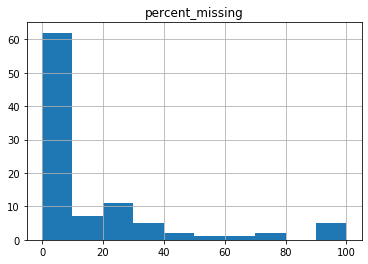

In [24]:
# Histogram of percent missing values
df_nullrows_percent.hist()

80 of 96 columns (83.3%) have less than 30% of their values miss and 62 of 96 columbs (64.58%) have less than 10% of their value miss. This makes it tempting to want to remove the columns with less than 10% of their values miss, but we do that we will miss all the columns related to reviews, so we are going to drop columns with mora than 30% of their values miss.

In [47]:
# Obtain the columns name that have less than 30% of their values miss
columns_lessthan30 = df_nullrows_percent[df_nullrows_percent["percent_missing"]<30]["column_name"].values.tolist()
# Filter the dataframe to have only those columns
df = df[columns_lessthan30]

In [ ]:
############_________ akadjdfjsdfjksdfksdfhata aqui camos

In [360]:
# en base a la exploracion data listin realzada en el archivo as, y a las preguntas realizaddas
# como primera iteracion se elimnan las columnas con mas de 20% valores perdidos y se conservanm las siguientes columas que
# tiene ralacion con nuestras preguntas y no tiene mas de 20% de valores faltantes

In [361]:
columns_of_interest = ['experiences_offered','host_location','host_response_time','host_response_rate',
                       'host_acceptance_rate','host_is_superhost','host_listings_count','host_total_listings_count',
                       'host_verifications','host_has_profile_pic','host_identity_verified','zipcode','city',
                       'latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds',
                       'bed_type','amenities','price','guests_included','extra_people','minimum_nights','maximum_nights',
                       'number_of_reviews','review_scores_rating','review_scores_cleanliness','review_scores_checkin',
                       'review_scores_communication','review_scores_location','review_scores_value','requires_license',
                       'instant_bookable','cancellation_policy','require_guest_profile_picture',
                       'require_guest_phone_verification','calculated_host_listings_count','reviews_per_month',
                       'occupation_percentage']

df = df[columns_of_interest]

In [362]:
# Use the describe function to understand and classify them to apply different strategies based on the information they contain
df.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
experiences_offered,7403,1,none,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_location,7384,277,"Seattle, Washington, United States",3260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_response_time,6409,4,within an hour,3076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_response_rate,6409,58,100%,4443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_acceptance_rate,6159,72,100%,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_is_superhost,7401,2,f,6216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_listings_count,7401.0,NaN,NaN,NaN,32.222537,123.585161,0.000000,1.000000,1.000000,4.000000,749.000000
host_total_listings_count,7401.0,NaN,NaN,NaN,32.222537,123.585161,0.000000,1.000000,1.000000,4.000000,749.000000
host_verifications,7403,136,"['email', 'phone', 'reviews', 'kba']",1208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_has_profile_pic,7401,2,t,7386,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
# Columns with unique values are removed because they do not add anything to the analysis
unique_value_columns = ["experiences_offered","requires_license"]
df = df.drop(unique_value_columns, axis=1)

In [364]:
'''
Columns with only true and false values and columns with few different values can be easily processed 
with the get_dummies function because it will not generate an exaggerated number of new columns
'''

boolean_value_columns = ["host_is_superhost","host_has_profile_pic","host_identity_verified","instant_bookable",
                         "require_guest_profile_picture","require_guest_phone_verification"]

categoricalfewvalues_columns = ["host_response_time","room_type","bed_type","cancellation_policy"]

boolean_fewvalues_columns = boolean_value_columns + categoricalfewvalues_columns

for var in  boolean_fewvalues_columns:
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    

In [365]:
# columnas que estan como categoricas pero deberian de ser continuas
categoricalbutwrong_columns = ["host_response_rate","host_acceptance_rate","price","extra_people"]
# modificacion columnas a continuas
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '', regex=False).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float)
# modifica columna price
df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price'] = df['price'].astype(float)
# modifica columna extra people
df['extra_people'] = df['extra_people'].str.replace('$', '', regex=False)
df['extra_people'] = df['extra_people'].str.replace(',', '', regex=False)
df['extra_people'] = df['extra_people'].astype(float)

In [366]:
# columnas complejas por la cantidad de diferentes valores que continen, aplicar dummi variables generaria muchas columnas
categoricalmanyvalues_columns = ["host_location","host_verifications","zipcode","city","property_type",
                                 "amenities"]

In [367]:
primero en city los valores que no sean boston y seattle pasarlos a nulos, despues host location 

SyntaxError: invalid syntax (<ipython-input-367-c8e31d84e91a>, line 1)

In [368]:
#Help function to mantain in city column just seattle or boston values, other value are change to nan
def check_city(value):
    if value == "Seattle" or value == "Boston":
        return value
    else: 
        return np.nan
    
# Apply the help function    
df['city'] = df['city'].apply(check_city)

In [369]:
#Funcuon integra clean host y aparte checa si esta in city
def host_isin_city(host_location,city):
    try:
        clean_host_location = host_location.split(",")[0]
        if clean_host_location == city:
            return True
        else:
            return False
    except AttributeError:
        return np.nan

df['host_in_city'] = df.apply(lambda x: host_isin_city(x.host_location, x.city), axis=1)
df = df.drop(["host_location"],axis=1)

In [370]:
# Drop rows with nan values in city column because the analisis is just for airbnbs in those citys
df = df.dropna(subset=['city'])
# get dummies
df = pd.concat([df.drop('city', axis=1), pd.get_dummies(df['city'], prefix='city', prefix_sep='_')], axis=1)

In [371]:
# Drop rows with nan values in host_in_city
df = df.dropna(subset=['host_in_city'])
# get dmmues
df = pd.concat([df.drop('host_in_city', axis=1), pd.get_dummies(df['host_in_city'], prefix='host_in_city', prefix_sep='_', drop_first=True)], axis=1)
# drip gos

In [ ]:
#solo temporal para ver si esta teniendo logica el modelo quitamos las variables falta procesar

In [372]:
df = df.drop(["host_verifications","property_type","amenities","zipcode","latitude","longitude"],axis=1)

In [373]:
df = df.dropna()

In [374]:
df

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,occupation_percentage,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,city_Boston,city_Seattle,host_in_city_True
1,100.0,100.0,1.0,1.0,2,1.0,1.0,1.0,65.0,0,0.0,2,15,36,94.0,9.0,10.0,10.0,9.0,9.0,1,1.30,1.643836,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1
2,100.0,88.0,1.0,1.0,2,1.0,1.0,1.0,65.0,1,20.0,3,45,41,98.0,9.0,10.0,10.0,9.0,10.0,1,0.47,12.602740,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1
3,100.0,50.0,1.0,1.0,4,1.0,1.0,2.0,75.0,2,25.0,1,1125,1,100.0,10.0,10.0,10.0,10.0,10.0,1,1.00,73.150685,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1
4,100.0,100.0,1.0,1.0,2,1.5,1.0,2.0,79.0,1,0.0,2,31,29,99.0,10.0,10.0,10.0,9.0,10.0,1,2.25,8.493151,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1
5,100.0,95.0,2.0,2.0,2,1.0,1.0,1.0,75.0,1,0.0,2,1125,8,100.0,10.0,10.0,10.0,9.0,10.0,1,1.70,84.109589,1,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395,100.0,100.0,1.0,1.0,5,1.0,2.0,3.0,154.0,4,50.0,2,14,5,92.0,8.0,10.0,10.0,10.0,8.0,1,1.56,37.808219,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1
7396,100.0,100.0,1.0,1.0,3,1.0,1.0,1.0,65.0,1,0.0,1,1125,2,100.0,8.0,10.0,10.0,10.0,10.0,1,0.63,39.452055,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1
7397,100.0,100.0,3.0,3.0,4,1.0,1.0,2.0,95.0,2,8.0,3,365,73,96.0,10.0,10.0,10.0,9.0,10.0,3,4.01,21.369863,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1
7398,99.0,100.0,354.0,354.0,6,2.0,3.0,3.0,359.0,1,0.0,3,1125,1,80.0,10.0,4.0,8.0,10.0,8.0,8,0.30,91.232877,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0


In [375]:
#Split data into an X matrix and a response vector y
y = df['occupation_percentage']
X = df.drop('occupation_percentage', axis=1)
#6. Create training and test sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
#7. Instantiate a LinearRegression model with normalized data
lm_model = LinearRegression(normalize=True)
#8. Fit your model to the training data
lm_model.fit(X_train, y_train)
#9. Predict the response for the training data and the test data
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
#10. Obtain an rsquared value for both the training and test data
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [376]:
test_score

0.10960016433573105

In [377]:
train_score

0.1098932727372437